<a href="https://colab.research.google.com/github/2j0123/WASSUP_Project_Team7_2/blob/US/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 정제 - 토큰화 - 불용어 제거/텍스트 정규화(표제어) - 텍스트 벡터화 / 감정 점수 - 모델 입력

### 파일을 불러오고 확인해 봅니다.

In [ ]:
import pandas as pd
df = pd.read_csv("//home//kdt-admin//woosung//files//drugsComTrain_raw.tsv", sep = '\t')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB
None


condition 컬럼에만 결측치가 있습니다.

In [ ]:
print(df.head())

   Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           1

### 데이터 제거 및 처리

In [ ]:
df.dropna(axis=0, inplace=True) # 결측치가 있는 행 많지 않아서 제거
df.drop(columns = ['Unnamed: 0', 'date'], inplace = True) # 날짜랑 문장 제거
df = df[~df['condition'].str.contains('</span>', case=False, na=False)] # 증상 이상한 것들 처리

html 변환 오류로 남아있는 문자 처리해 줍니다.

In [ ]:
import html
df['review']=df['review'].apply(html.unescape)#html 문자 처리

영어, 숫자 남기고 제거, 소문자로 변환

In [ ]:
import re
df['review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['review'] = df['review'].str.lower()
df['drugName'] = df['drugName'].str.lower()
df['condition'] = df['condition'].str.lower()

In [ ]:
print(df['drugName'].nunique( )) #몇 개의 값들이 있는지
print(df['condition'].nunique( )) #몇 개의 값들이 있는지

3412
811


usefulcount 낮은 것들을 처리해야 할 것 같습니다.


### 시각화

In [ ]:
from matplotlib import pyplot as plt

usefulcount 분포를 확인해 봅시다.

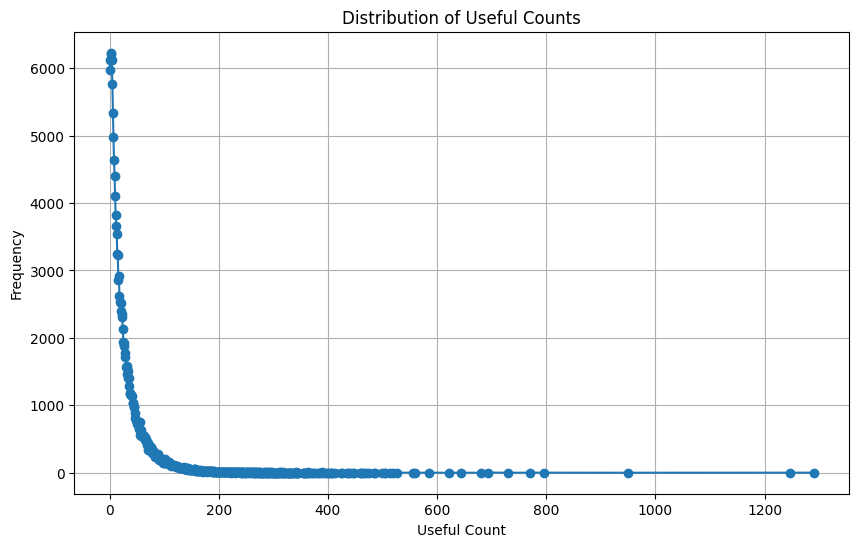

In [ ]:
useful_counts = df['usefulCount'].value_counts()

# 빈도수 데이터를 'usefulcount' 값에 따라 정렬
useful_counts= useful_counts.sort_index()

# 선형 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(useful_counts.index, useful_counts.values, marker='o', linestyle='-')
plt.title('Distribution of Useful Counts')
plt.xlabel('Useful Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
df=df[(df['usefulCount'] != 0) & (df['usefulCount'] != 1)] # 공감 못 받은 값들 제거.

평점 분포를 확인해 봅시다.

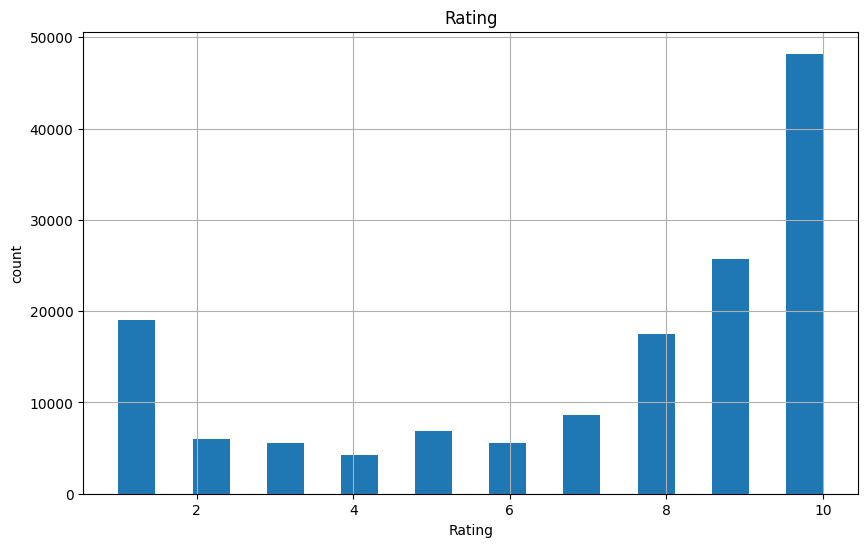

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=19)
plt.title('Rating')
plt.xlabel('Rating')
plt.ylabel('count')
plt.grid(True)
plt.show()

rating 10점이 좀 많은 것을 알 수 있습니다.

어떤 약이 많이 쓰이는지 확인해 봅시다.

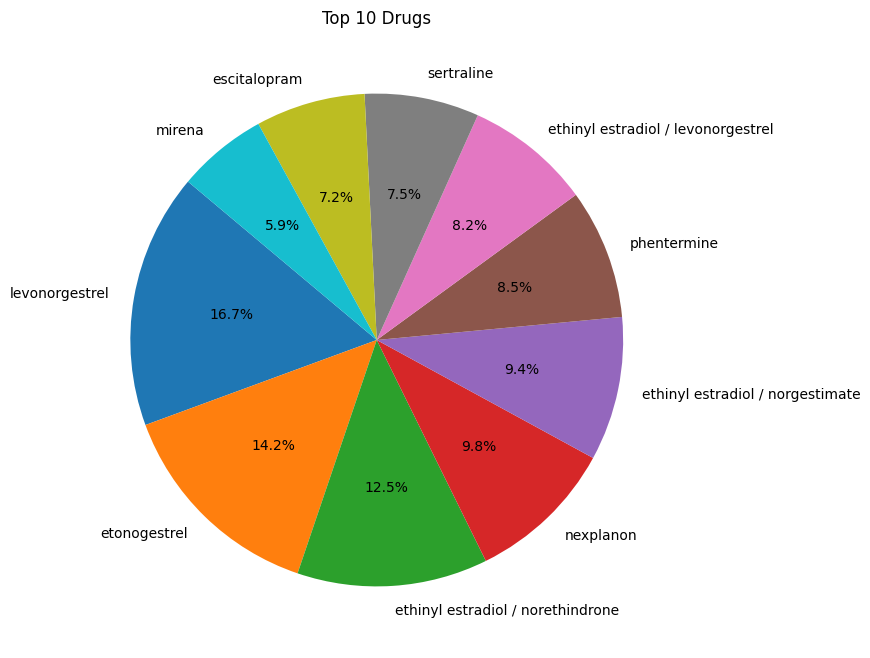

In [ ]:
# 상위 10개 약물 선택
top_drugs = df['drugName'].value_counts().head(10)

# 원형 그래프
plt.figure(figsize=(8, 8))
top_drugs.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Drugs')
plt.ylabel('')
plt.show()

condition 상위 10개

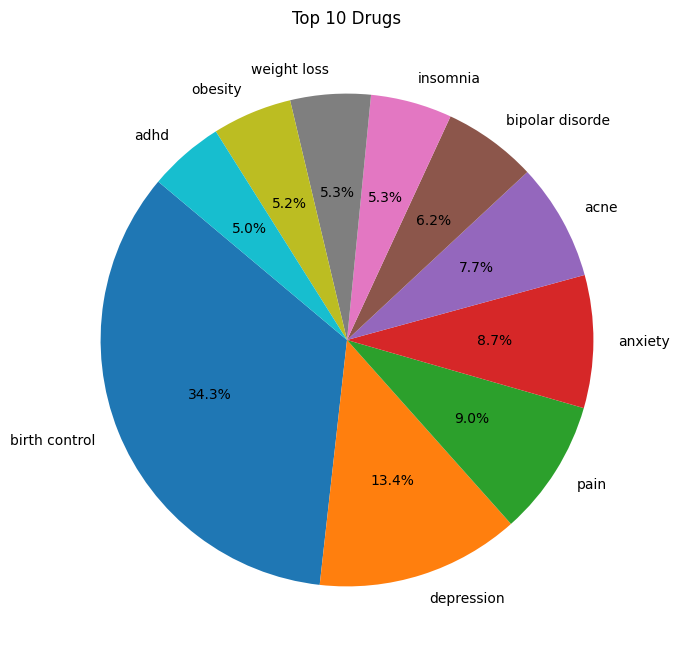

In [ ]:
# 상위 10개 증상 선택
top_drugs = df['condition'].value_counts().head(10)

# 원형 그래프
plt.figure(figsize=(8, 8))
top_drugs.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Drugs')
plt.ylabel('')
plt.show()

약들의 평균 평점을 구해봅시다.

In [ ]:
average_ratings = df.groupby('drugName')['rating'].mean().reset_index()

# 결과 출력
print(average_ratings)

                                  drugName     rating
0                a + d cracked skin relief  10.000000
1                               a / b otic  10.000000
2     abacavir / dolutegravir / lamivudine   8.446809
3                                abatacept   7.157895
4                                  abilify   6.611494
...                                    ...        ...
3170                                zyrtec   7.378788
3171                      zyrtec-d 12 hour  10.000000
3172                                zytiga   9.714286
3173                                 zyvox   9.000000
3174                               zzzquil   2.500000

[3175 rows x 2 columns]


In [ ]:
# rating이 너무 이상한 값들 제거
df_original=df.copy()
drops = []

for drug in df['drugName'].unique():
    group = df[df['drugName'] == drug]

    Q1 = group['rating'].quantile(0.25)
    Q3 = group['rating'].quantile(0.75)
    IQR = Q3 - Q1

    condition = (group['rating'] < (Q1 - 3 * IQR)) | (group['rating'] > (Q3 + 3 * IQR))
    drops.extend(group[condition].index)

# 이상치를 포함하는 행을 제거
df.drop(index=drops, inplace=True)

리뷰의 길이가 어느정도인지 확인해 봅시다.

In [ ]:
# 각 리뷰의 길이를 계산합니다.
df['length'] = df['review'].apply(len)

print(f"가장 짧은 문장 길이: {df['length'].min()}")
print(f'위치는 {df['length'].idxmin()}')
print(f"가장 긴 문장 길이: {df['length'].max()}")
print(f'위치는 {df['length'].idxmax()}')
import numpy as np
print('리뷰 길이 평균값: {:.2f}'.format((df['length']).mean()))
print('리뷰 길이 표준편차: {:.2f}'.format(df['length'].std()))
print('리뷰 길이 중간값: {}'.format(df['length'].median()))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(df['length'],25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(df['length'],75)))

가장 짧은 문장 길이: 1
위치는 10605
가장 긴 문장 길이: 10126
위치는 75663
리뷰 길이 평균값: 434.83
리뷰 길이 표준편차: 230.55
리뷰 길이 중간값: 432.0
리뷰 길이 제1사분위: 247.0
리뷰 길이 제3사분위: 656.0


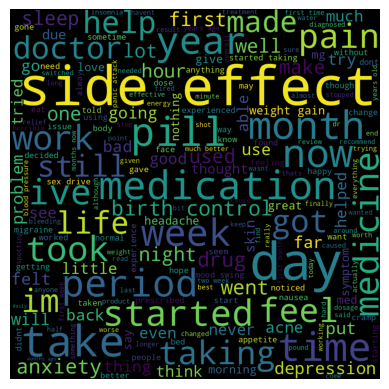

In [ ]:
from wordcloud import WordCloud
wordcloud=WordCloud(width=1000,height=1000).generate(' '.join(df['review']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
dict = average_ratings.set_index('drugName')['rating'].to_dict()
df['average_rating_drug'] = df['drugName'].map(dict)

In [ ]:
print(df['review'].nunique( )) #최대 4만개의 중복된 리뷰들이 있음 - 두개를 구입한 경우.

101198


In [ ]:
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 8 else (0 if x >= 4 else -1))

증상당 몇개의 약이 있는지 확인해 봅시다.

Text(0.5, 1.0, 'Top20 : The number of drug per condition')

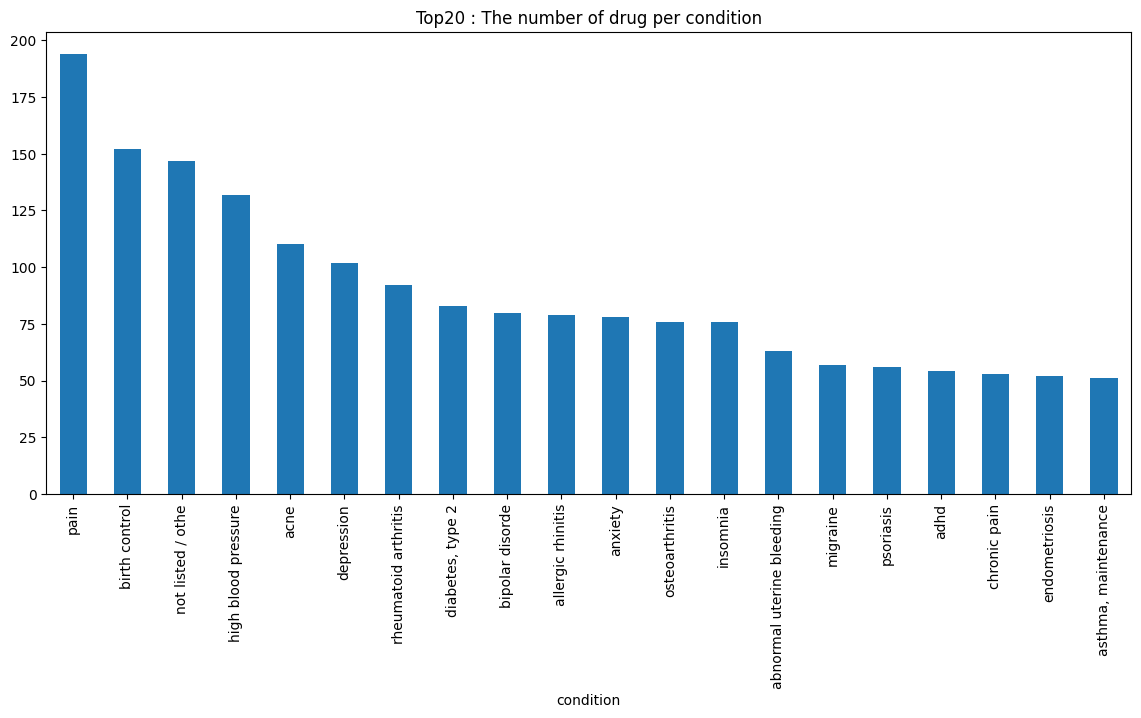

In [ ]:
condition_df=df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_df[:20].plot(kind='bar',figsize=(14,6))
plt.title('Top20 : The number of drug per condition')

In [ ]:
from tqdm import tqdm
import time

### 토큰화 - nltk 불용어 처리

In [ ]:
import nltk
import string
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')

# 빈도수 계산을 위한 리스트 초기화
li = []
stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation)
# df의 모든 리뷰에 대해 반복
for review in tqdm(df['review']):
    # 토큰화
    tokens = nltk.word_tokenize(review)
    # 불용어 및 구두점 제거
    filtered_tokens = [t for t in tokens if t.lower() not in stopwords]
    li.extend(filtered_tokens)

# 단어 빈도수 계산
word_counts = Counter(li)

# 빈도수가 높은 순으로 정렬
word_counts = word_counts.most_common()

# 인코딩 (빈도수 순으로 1부터 인코딩)
word_encoding = {word: i+1 for i, (word, _) in enumerate(word_counts)}

[nltk_data] Downloading package punkt to /home/kdt-admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 145403/145403 [00:32<00:00, 4528.30it/s]


In [ ]:
word_encoding

{'day': 1,
 'im': 2,
 'side': 3,
 'taking': 4,
 'years': 5,
 'ive': 6,
 'pain': 7,
 'effects': 8,
 'take': 9,
 'first': 10,
 'started': 11,
 'months': 12,
 'like': 13,
 'get': 14,
 'days': 15,
 'time': 16,
 'feel': 17,
 '2': 18,
 'would': 19,
 'back': 20,
 '3': 21,
 'one': 22,
 'weeks': 23,
 'pill': 24,
 'medication': 25,
 'also': 26,
 'took': 27,
 'week': 28,
 'doctor': 29,
 'weight': 30,
 'life': 31,
 'got': 32,
 'dont': 33,
 'since': 34,
 'period': 35,
 'month': 36,
 'still': 37,
 'anxiety': 38,
 'bad': 39,
 'much': 40,
 'really': 41,
 'better': 42,
 'medicine': 43,
 'went': 44,
 'work': 45,
 'never': 46,
 'two': 47,
 'well': 48,
 'felt': 49,
 'every': 50,
 'good': 51,
 'didnt': 52,
 'great': 53,
 'night': 54,
 'sleep': 55,
 'even': 56,
 'year': 57,
 'go': 58,
 'control': 59,
 'tried': 60,
 'ago': 61,
 'works': 62,
 '4': 63,
 'drug': 64,
 'hours': 65,
 'dose': 66,
 'depression': 67,
 'little': 68,
 'made': 69,
 'last': 70,
 'worked': 71,
 'prescribed': 72,
 'going': 73,
 'mg': 74,
 

In [ ]:
print(len(word_encoding))

71161


### 토큰화 및 전처리 - Spacy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm') #en_core_web_md 나 en_core_web_lg도 가능
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'make', 'itself', 'hence', 'few', 'whereas', 'our', 'becoming', 'due', 'became', 'ourselves', 'eleven', '’re', 'six', 'hers', 'those', 'own', 'perhaps', 'other', 'further', 'do', 'herein', 'through', "'m", 'give', 'sixty', 'was', 'move', 'throughout', 'someone', 'because', 'three', 'keep', 'amount', 'being', '‘s', 'are', "'re", 'whenever', 'many', 'part', 'whom', 'nothing', 'might', 'has', 'himself', 'upon', 'us', 'cannot', 'else', 'yourself', 'me', 'never', 'serious', 'seeming', 'wherein', 'seem', 'n’t', 'they', 'everywhere', 'twelve', 'onto', 'since', 'beforehand', 'mostly', 'themselves', "n't", 'n‘t', '’ll', 'you', 'wherever', 'used', 'fifteen', 'under', 'no', 'among', 'twenty', 'below', 'nobody', 'around', 're', 'several', 'beyond', 'anything', 'everyone', 'his', 'rather', 'sometimes', "'ll", 'were', 'every', 'at', 'least', 'of', 'moreover', 'something', 'until', 'same', 'herself', 'whither', 'made', 'former', 'get', 'put', 'both', 'all', 'into', 'very', '‘re', '’m', 'whoever', 'y

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')
import string
from collections import Counter
custom_stopwords = ['\r', '\n', '\r\n', '\r\r\n','\r\n\r\n','\r\r\n\r\r\n']
# 빈도수 계산을 위한 리스트 초기화
li = []
stopwords = spacy.lang.en.stop_words.STOP_WORDS
# df의 모든 리뷰에 대해 반복
for review in tqdm(df['review']):
    # 토큰화
    review=nlp(review)
    filtered_tokens = [token.lemma_ for token in review if not token.is_stop and not token.is_punct and token.text not in custom_stopwords and not token.is_space and token.lemma_.lower() not in stopwords ]
    #print(filtered_tokens)
    li.extend(filtered_tokens)

# 단어 빈도수 계산
word_counts = Counter(li)

# 빈도수가 높은 순으로 정렬
word_counts = word_counts.most_common()

# 인코딩 (빈도수 순으로 1부터 인코딩)
word_encoding = {word: i+1 for i, (word, _) in enumerate(word_counts)}

100%|██████████| 145403/145403 [28:00<00:00, 86.53it/s] 


In [ ]:
word_encoding

{'day': 1,
 'feel': 2,
 'month': 3,
 'year': 4,
 'work': 5,
 'week': 6,
 'start': 7,
 'effect': 8,
 'm': 9,
 'time': 10,
 'pain': 11,
 've': 12,
 'mg': 13,
 'like': 14,
 'bad': 15,
 'pill': 16,
 'try': 17,
 'period': 18,
 'help': 19,
 '2': 20,
 'medication': 21,
 'doctor': 22,
 '3': 23,
 'good': 24,
 'weight': 25,
 'medicine': 26,
 'life': 27,
 'experience': 28,
 'sleep': 29,
 'stop': 30,
 'anxiety': 31,
 'hour': 32,
 'think': 33,
 'night': 34,
 'control': 35,
 'great': 36,
 'gain': 37,
 'drug': 38,
 'dose': 39,
 'lose': 40,
 'thing': 41,
 '5': 42,
 'ago': 43,
 'long': 44,
 '4': 45,
 '10': 46,
 'prescribe': 47,
 'depression': 48,
 'little': 49,
 'acne': 50,
 'know': 51,
 'find': 52,
 'come': 53,
 'problem': 54,
 'eat': 55,
 'change': 56,
 'want': 57,
 'birth': 58,
 'headache': 59,
 'severe': 60,
 'lot': 61,
 'need': 62,
 '6': 63,
 'recommend': 64,
 'cramp': 65,
 'mood': 66,
 'notice': 67,
 'use': 68,
 'far': 69,
 'tell': 70,
 'symptom': 71,
 'away': 72,
 'skin': 73,
 'cause': 74,
 '1':

In [ ]:
print(len(word_encoding))

63158


숫자는 어떻게?

### 단어별로 평균 평점 확인

In [ ]:
token = 'bless'

# 해당 토큰을 포함하는 행들을 필터링하고, 이들 행의 'rating' 열에 대한 평균을 계산
average_rating = df[df['review'].str.contains(token)]['rating'].mean()

print(f"'{token}' 토큰이 있는 문장의 평균 평점 : {average_rating}")

'bless' 토큰이 있는 문장의 평균 평점 : 8.91782729805014


대부분 7점 초반 6점 후반
side: 7.33? side effect: 7.41 negative: 7.5 anymore 6.96 immediately 6.3 shits: 7.45 nothing 7.08


fuck 2.71
fucking 2.33
shit 5.79
crazy 5.9
awful 5.5
suck 6.15
pain 6.75
bad 6.71
still 6.6
never 6.34
ruin/ruined 4.0

god 7.2
thankfully 7.4
nice 7.5
perfect 7.8
perfectly 7.65
great : 7.9
life : 7.92
thanks : 8.1
best: 8.5
fantastic: 8.6
bless: 8.9
miracle: 9.12
saved: 9.4

앞으로 해야 할 것
1. 단어의 문장에서의 감정 점수에 따라 높은 문장 찾기. - sentiword, vader 공부중.
2. 문장에서의 쓰임에 따라 단어 점수 유동적으로

워드 인코딩 파일 저장

In [ ]:
import pickle

# word_encoding 딕셔너리를 파일로 저장하기
with open('word_encoding.pickle', 'wb') as file:
    pickle.dump(word_encoding, file)

In [ ]:
df.to_csv('/home/kdt-admin/woosung/files/drug_eda.tsv', sep='\t', index=False)

워드 인코딩 파일 가져오기

In [ ]:
import pickle
import pandas as pd

In [ ]:
# 파일에서 word_encoding 딕셔너리 불러오기
with open('word_encoding.pickle', 'rb') as file:
    loaded_word_encoding = pickle.load(file)

# 불러온 딕셔너리 사용하기
print(loaded_word_encoding)

{'day': 1, 'feel': 2, 'month': 3, 'year': 4, 'work': 5, 'week': 6, 'start': 7, 'effect': 8, 'm': 9, 'time': 10, 'pain': 11, 've': 12, 'mg': 13, 'like': 14, 'bad': 15, 'pill': 16, 'try': 17, 'period': 18, 'help': 19, '2': 20, 'medication': 21, 'doctor': 22, '3': 23, 'good': 24, 'weight': 25, 'medicine': 26, 'life': 27, 'experience': 28, 'sleep': 29, 'stop': 30, 'anxiety': 31, 'hour': 32, 'think': 33, 'night': 34, 'control': 35, 'great': 36, 'gain': 37, 'drug': 38, 'dose': 39, 'lose': 40, 'thing': 41, '5': 42, 'ago': 43, 'long': 44, '4': 45, '10': 46, 'prescribe': 47, 'depression': 48, 'little': 49, 'acne': 50, 'know': 51, 'find': 52, 'come': 53, 'problem': 54, 'eat': 55, 'change': 56, 'want': 57, 'birth': 58, 'headache': 59, 'severe': 60, 'lot': 61, 'need': 62, '6': 63, 'recommend': 64, 'cramp': 65, 'mood': 66, 'notice': 67, 'use': 68, 'far': 69, 'tell': 70, 'symptom': 71, 'away': 72, 'skin': 73, 'cause': 74, '1': 75, 'nausea': 76, 'normal': 77, 'sex': 78, 'morning': 79, 'old': 80, 'lov

In [ ]:
df = pd.read_csv("//home//kdt-admin//woosung//files//drug_eda.tsv", sep = '\t')

In [ ]:
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')
import string
from collections import Counter
custom_stopwords = ['\r', '\n', '\r\n', '\r\r\n','\r\n\r\n','\r\r\n\r\r\n']
# 빈도수 계산을 위한 리스트 초기화
stopwords = spacy.lang.en.stop_words.STOP_WORDS
# df의 모든 리뷰에 대해 반복
def process_review(review):
    doc = nlp(review)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and token.text not in custom_stopwords and token.lemma_.lower() not in stopwords]

df['tokenized_review'] = df['review'].apply(process_review)

### 모델링

In [ ]:
X=df['condition']
y=df['drugName']
review=df['review']

In [ ]:
# 모델에 필요한 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2024-04-03 06:01:28.463758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 06:01:29.532395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
